**Import libraries**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import warnings
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


**Load data**

In [17]:

import pandas as pd

# Load the transactions data from a CSV file
data = pd.read_csv('creditdata.csv')

# Display a preview of the data
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Transaction_ID
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


**Scale data**

In [18]:
numerical_features = data.drop('Class', axis=1).select_dtypes(include=[np.number]).columns.tolist()

scaler = RobustScaler()

scaled_numerical = scaler.fit_transform(data[numerical_features])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features).astype('float32')

scaled_data = pd.concat([scaled_numerical_df, data[['Class']]], axis=1)

X = scaled_data.drop('Class', axis=1)
y = scaled_data['Class']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

if X.isnull().values.any():
    X = X.dropna()
    y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X: (284807, 31)
Shape of y: (284807,)
Training set shape: X_train: (227845, 31), y_train: (227845,)
Testing set shape: X_test: (56962, 31), y_test: (56962,)


**Handle imbalances**

In [19]:

smote = SMOTE()
try:
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Original dataset shape: {y_train.value_counts()}")
    print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")
except ValueError as e:
    print(f"Error during SMOTE resampling: {e}")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Unique classes in y_train: {y_train.unique()}")
    raise


Original dataset shape: Class
0    227451
1       394
Name: count, dtype: int64
Resampled dataset shape: Class
0    227451
1    227451
Name: count, dtype: int64


**Train, optimize, and evaluate random forest**

Best Random Forest AUPRC (Training Set): 0.9999999999613407


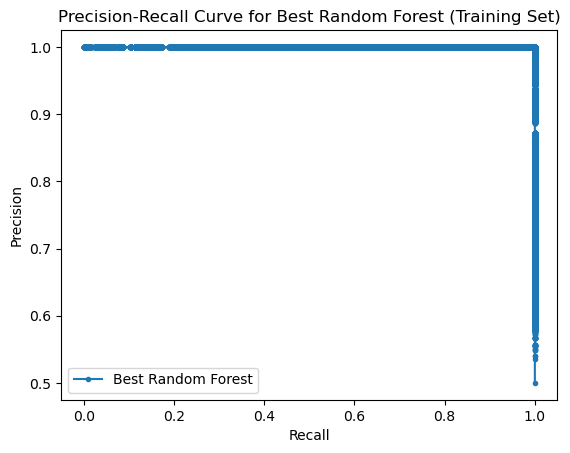

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Define the Random Forest classifier with predefined parameters
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

try:
    # Fit the Random Forest model on the resampled training data
    rf.fit(X_resampled, y_resampled)
    best_rf = rf  # Assign the trained model to best_rf
    
    # Predict probabilities and calculate AUPRC
    y_scores_best_rf = best_rf.predict_proba(X_resampled)[:, 1]
    auprc_best_rf = average_precision_score(y_resampled, y_scores_best_rf)
    print(f"Best Random Forest AUPRC (Training Set): {auprc_best_rf}")
    
    # Plot the Precision-Recall curve
    precision_best_rf, recall_best_rf, _ = precision_recall_curve(y_resampled, y_scores_best_rf)
    plt.plot(recall_best_rf, precision_best_rf, marker='.', label='Best Random Forest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best Random Forest (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during training for Random Forest: {e}")

**Train, optimize, and Evaluate XGBoost**

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.7}
Best XGBoost AUPRC (Training Set): 0.9999999968868881


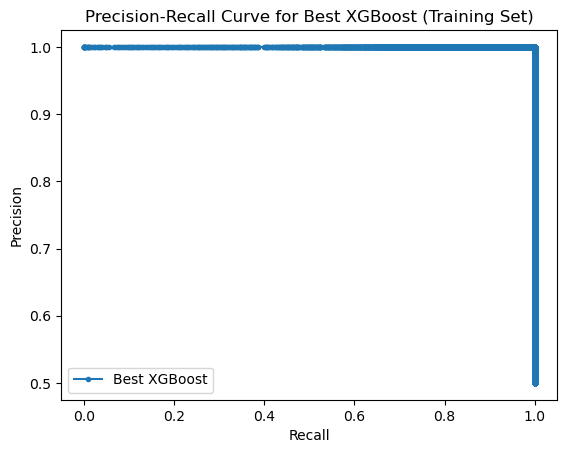

In [21]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [(y_resampled==0).sum() / (y_resampled==1).sum()]
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='average_precision',
    n_jobs=1,
    verbose=1
)

try:
    grid_search_xgb.fit(X_resampled, y_resampled)
    print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
    best_xgb = grid_search_xgb.best_estimator_
    
    y_scores_best_xgb = best_xgb.predict_proba(X_resampled)[:, 1]
    auprc_best_xgb = average_precision_score(y_resampled, y_scores_best_xgb)
    print(f"Best XGBoost AUPRC (Training Set): {auprc_best_xgb}")
    
    precision_best_xgb, recall_best_xgb, _ = precision_recall_curve(y_resampled, y_scores_best_xgb)
    plt.plot(recall_best_xgb, precision_best_xgb, marker='.', label='Best XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best XGBoost (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during GridSearchCV for XGBoost: {e}")


**Train, optimize, and evaluate LGBM**

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 31
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: gfx1102, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.88 MB) transferred to GPU in 0.011532 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best LightGBM AUPRC (Training Set): 0.9975084949925699


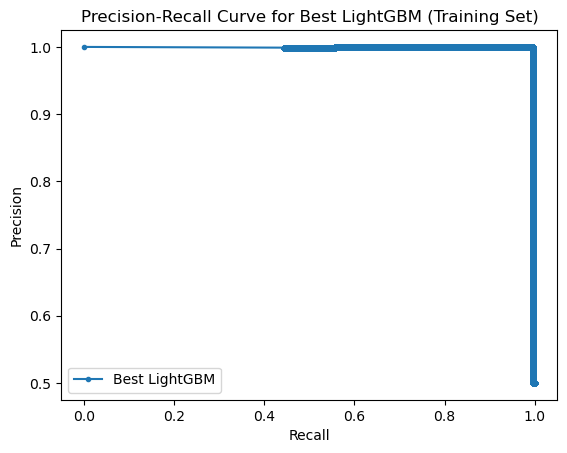

In [22]:
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Define the LightGBM classifier with predefined parameters
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=(y_resampled==0).sum() / (y_resampled==1).sum(),
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    class_weight='balanced',
    random_state=42
)

try:
    # Fit the LightGBM model on the resampled training data
    lgbm.fit(X_resampled, y_resampled)
    best_lgbm = lgbm  # Assign the trained model to best_lgbm
    
    # Predict probabilities and calculate AUPRC
    y_scores_best_lgbm = best_lgbm.predict_proba(X_resampled)[:, 1]
    auprc_best_lgbm = average_precision_score(y_resampled, y_scores_best_lgbm)
    print(f"Best LightGBM AUPRC (Training Set): {auprc_best_lgbm}")
    
    # Plot the Precision-Recall curve
    precision_best_lgbm, recall_best_lgbm, _ = precision_recall_curve(y_resampled, y_scores_best_lgbm)
    plt.plot(recall_best_lgbm, precision_best_lgbm, marker='.', label='Best LightGBM')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best LightGBM (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during training for LightGBM: {e}")

**Plot the precision-recall curves for all models**

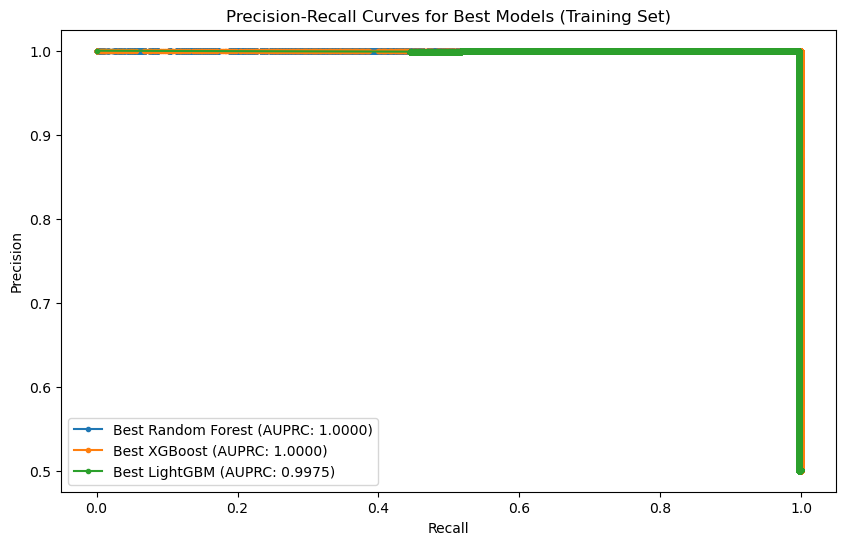

In [23]:
plt.figure(figsize=(10, 6))

# Random Forest
plt.plot(recall_best_rf, precision_best_rf, marker='.', label='Best Random Forest (AUPRC: {:.4f})'.format(auprc_best_rf))

# XGBoost
plt.plot(recall_best_xgb, precision_best_xgb, marker='.', label='Best XGBoost (AUPRC: {:.4f})'.format(auprc_best_xgb))

# LightGBM
plt.plot(recall_best_lgbm, precision_best_lgbm, marker='.', label='Best LightGBM (AUPRC: {:.4f})'.format(auprc_best_lgbm))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Models (Training Set)')
plt.legend()
plt.show()


**Evaluate the models on the testing set**

AUPRC Scores on Testing Set:
                Model     AUPRC
0  Best Random Forest  0.861800
1        Best XGBoost  0.886414
2       Best LightGBM  0.525310


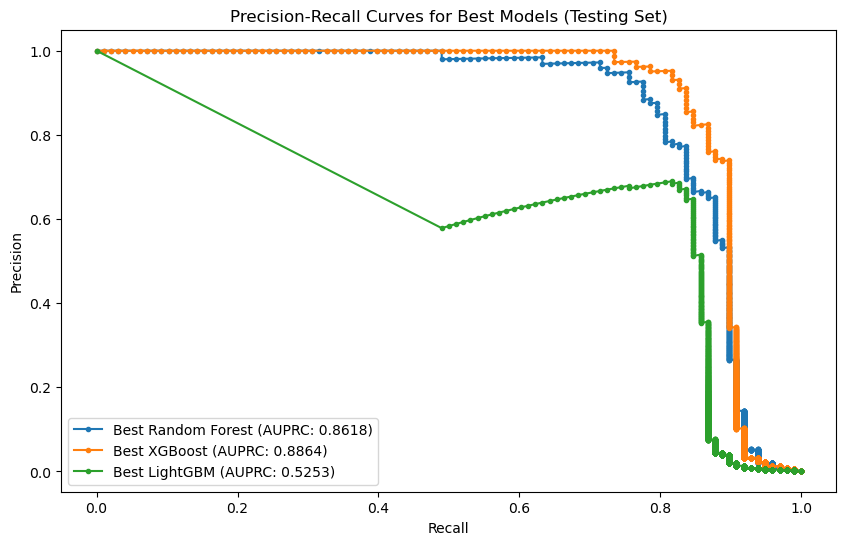

In [24]:

models = {
    'Best Random Forest': best_rf,
    'Best XGBoost': best_xgb,
    'Best LightGBM': best_lgbm
}

test_auprc = pd.DataFrame(columns=['Model', 'AUPRC'])
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    y_scores_test = model.predict_proba(X_test)[:, 1]
    
    auprc = average_precision_score(y_test, y_scores_test)
    new_row = pd.DataFrame({'Model': [model_name], 'AUPRC': [auprc]})
    test_auprc = pd.concat([test_auprc, new_row], ignore_index=True)
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores_test)
    
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC: {auprc:.4f})')

print("AUPRC Scores on Testing Set:")
print(test_auprc)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Models (Testing Set)')
plt.legend()
plt.show()


Stacking Ensemble trained successfully.
Stacking Ensemble AUPRC (Training Set): 0.9999999899430625


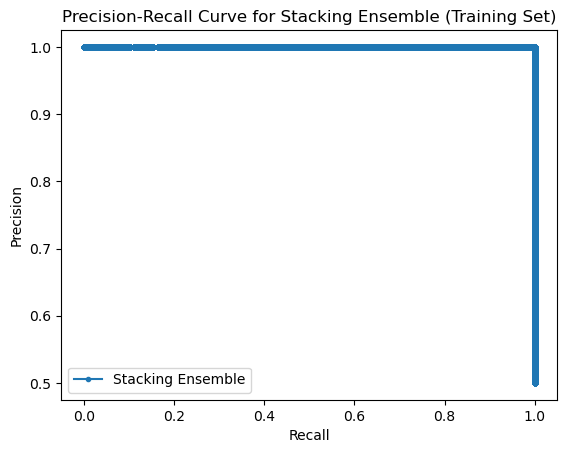

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base estimators
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgbm', best_lgbm)
]

# Define the meta-classifier
meta_classifier = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    passthrough=False,  # If True, the original features are concatenated with the base estimators' predictions
    stack_method='auto'  # Automatically choose the stacking method
)

# Train the stacking classifier on the resampled training data
try:
    stacking_clf.fit(X_resampled, y_resampled)
    print("Stacking Ensemble trained successfully.")
    
    # Predict probabilities on the resampled training set
    y_scores_stacking = stacking_clf.predict_proba(X_resampled)[:, 1]
    auprc_stacking = average_precision_score(y_resampled, y_scores_stacking)
    print(f"Stacking Ensemble AUPRC (Training Set): {auprc_stacking}")
    
    # Plot the Precision-Recall curve for the stacking ensemble
    precision_stacking, recall_stacking, _ = precision_recall_curve(y_resampled, y_scores_stacking)
    plt.plot(recall_stacking, precision_stacking, marker='.', label='Stacking Ensemble')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Stacking Ensemble (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during training for Stacking Ensemble: {e}")


AUPRC Scores on Testing Set:
                Model     AUPRC
0  Best Random Forest  0.861800
1        Best XGBoost  0.886414
2       Best LightGBM  0.525310
3   Stacking Ensemble  0.872370


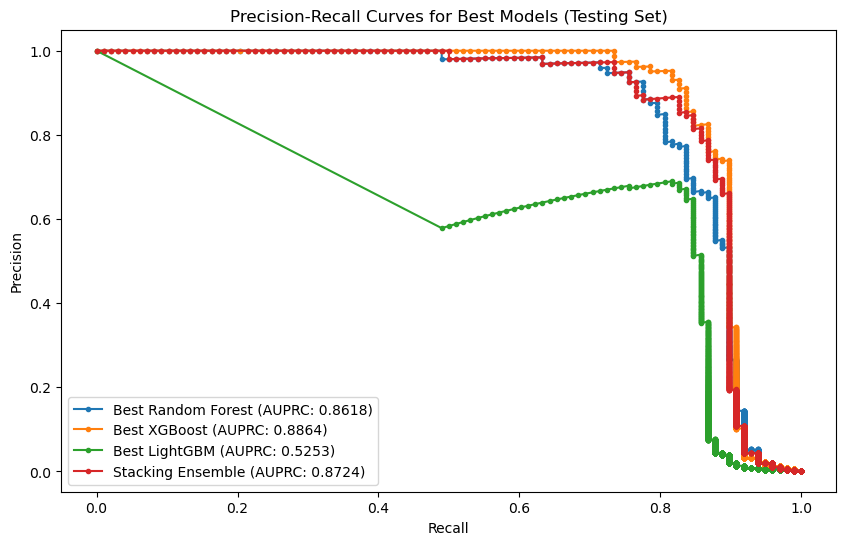

In [26]:
# Initialize a DataFrame to store AUPRC scores
test_auprc = pd.DataFrame(columns=['Model', 'AUPRC'])

plt.figure(figsize=(10, 6))

# List of models including the stacking ensemble
models = {
    'Best Random Forest': best_rf,
    'Best XGBoost': best_xgb,
    'Best LightGBM': best_lgbm,
    'Stacking Ensemble': stacking_clf
}

for model_name, model in models.items():
    try:
        # Predict probabilities on the test set
        y_scores_test = model.predict_proba(X_test)[:, 1]
        
        # Calculate AUPRC
        auprc = average_precision_score(y_test, y_scores_test)
        new_row = pd.DataFrame({'Model': [model_name], 'AUPRC': [auprc]})
        test_auprc = pd.concat([test_auprc, new_row], ignore_index=True)
        
        # Plot the Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_scores_test)
        plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC: {auprc:.4f})')
    except Exception as e:
        print(f"An error occurred during prediction for {model_name}: {e}")

print("AUPRC Scores on Testing Set:")
print(test_auprc)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Models (Testing Set)')
plt.legend()
plt.show()


**Store models**

In [31]:

y_pred_proba = stacking_clf.predict_proba(X)[:, 1]

# Save the predictions to a CSV file for Tableau
predictions = pd.DataFrame({
    'Transaction_ID': data['Transaction_ID'],
    'Fraud_Probability': y_pred_proba
})
predictions.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

#accuracy score:
from sklearn.metrics import accuracy_score
y_pred = stacking_clf.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Predictions saved to predictions.csv
Accuracy: 0.9998
